In [1]:
import tensorflow as tf
import numpy as np

# GETTING THE DATA

In [2]:
import pandas as pd
df = pd.read_csv('BTC_USD_2014-11-04_2021-12-03-CoinDesk.csv',
                parse_dates = ["Date"],
                index_col = ["Date"])

In [3]:
df.head(10)

Currency  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
Date                                                                       
2014-11-04      BTC           324.467934      323.826186      333.539527   
2014-11-05      BTC           328.644408      324.424164      330.671610   
2014-11-06      BTC           337.921358      328.653046      342.384170   
2014-11-07      BTC           348.992860      337.921358      352.585895   
2014-11-08      BTC           341.459753      348.992860      351.651854   
2014-11-09      BTC           344.745289      341.459753      346.475560   
2014-11-10      BTC           357.239982      344.745289      357.986991   
2014-11-11      BTC           371.116917      371.116917      371.116917   
2014-11-12      BTC           366.664633      367.921363      370.800015   
2014-11-13      BTC           428.882925      366.789056      435.484664   

            24h Low (USD)  
Date                       
2014-11-04     323.106623  
2014-11-05     320.902900  
2014-11-06     328.597125  
2014-11-07     336.236830  
2014-11-08     340.196145  
2014-11-09     340.357542  
2014-11-10     342.082083  
2014-11-11     371.116917  
2014-11-12     361.225098  
2014-11-13     366.598986

In [4]:
df.describe()

Closing Price (USD)  24h Open (USD)  24h High (USD)  24h Low (USD)
count          2587.000000     2587.000000     2587.000000    2587.000000
mean          10506.981786    10485.620695    10795.323022   10140.408762
std           15358.759450    15333.933630    15782.180264   14824.926480
min             178.016008      178.016008      211.673245     169.146791
25%             612.405587      611.768016      615.590685     607.477402
50%            6193.620000     6189.560458     6346.690000    6016.419870
75%           10142.146805    10134.557348    10377.445994    9739.233235
max           67553.948930    67554.840000    68990.900000   66316.000000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2587 entries, 2014-11-04 to 2021-12-03
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2587 non-null   object 
 1   Closing Price (USD)  2587 non-null   float64
 2   24h Open (USD)       2587 non-null   float64
 3   24h High (USD)       2587 non-null   float64
 4   24h Low (USD)        2587 non-null   float64
dtypes: float64(4), object(1)
memory usage: 121.3+ KB


In [6]:
# we will only predict the closing price
df_cp = pd.DataFrame(df['Closing Price (USD)']).rename(columns = {'Closing Price (USD)':'Price'})

In [7]:
df_cp.head()

Price
Date                  
2014-11-04  324.467934
2014-11-05  328.644408
2014-11-06  337.921358
2014-11-07  348.992860
2014-11-08  341.459753

# PLOTTING OUR DATA

In [8]:
import matplotlib.pyplot as plt
df_cp.plot(figsize=(10,7))

<AxesSubplot:xlabel='Date'>

# CREATING TRAINING AND TEST DATA (the incorrect way)

In [9]:
prices = df_cp['Price'].to_numpy()
timesteps = df_cp.index.to_numpy()
prices[:10],timesteps[:10]

(array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
        344.745289, 357.239982, 371.116917, 366.664633, 428.882925]),
 array(['2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
        '2014-11-06T00:00:00.000000000', '2014-11-07T00:00:00.000000000',
        '2014-11-08T00:00:00.000000000', '2014-11-09T00:00:00.000000000',
        '2014-11-10T00:00:00.000000000', '2014-11-11T00:00:00.000000000',
        '2014-11-12T00:00:00.000000000', '2014-11-13T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [10]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(timesteps,
                                             prices,
                                            test_size = 0.2,
                                            random_state = 42)

In [11]:
plt.figure(figsize=(10,7))
plt.title("TRAIN AND TEST DATA POINTS")
plt.scatter(xtrain,ytrain,s=10)
plt.scatter(xtest,ytest,s=10)
plt.legend(["TRAIN","TEST"])
plt.grid(True)
#WE CAN SEE THAT THERE IS A SLIGHT DATA LEAK SINCE WE WILL BE MISSING OUT ON A FEW TRAINING POINTS SINCE THEY HAVE BECOME A 
#PART OF THE TEST DATA

# CREATING TRAINING AND TEST DATA (the correct way)

In [12]:
trainlen = int(len(timesteps)*0.8)
xtrain = timesteps[:trainlen]
xtest = timesteps[trainlen:]
ytrain = prices[:trainlen]
ytest = prices[trainlen:]
len(xtrain),len(ytrain),len(xtest),len(ytest)

(2069, 2069, 518, 518)

# CREATING FUNCTION TO VISUALIZE TIME SERIES DATA

In [13]:
def plot_timeseries(timesteps,values,label = None,format = '.',start = 0):
    plt.plot(timesteps[start:],values[start:],format,label=label)
    plt.xlabel("TIMESTEPS")
    plt.ylabel("VALUES")
    plt.legend()

In [14]:
plt.figure(figsize=(10,7))
plot_timeseries(xtrain,ytrain,label="TRAIN",format='-')
plot_timeseries(xtest,ytest,label="TEST",format='-')

# LIST OF MODELLING EXPERIMENTS:
| EXPERIMENT NUMBER | EXPERIMENT NAME 
| :- | :-:
| 0 | NAIVE MODEL(BASELINE) 
| 1 | DENSE MODEL HORIZON = 1, WINDOW SIZE = 7 
| 2 | DENSE MODEL 2 HORIZON = 1, WINDOW SIZE = 30
| 3 | DENSE MODEL 3 HORIZON = 7, WINDOW SIZE = 30
| 4 | CONV-1D 
| 5 | LSTM 
| 6 | DENSE MODEL 4 
| 7 | N-BEATS ALGORITHM 
| 8 | ENSEMBLE 


# NAIVE MODEL 

In [15]:
# the naive model forecasts the current value as the next value and it is very difficult to beat the results of the 
# baseline naive model
naive_forecast = ytest[:-1]
ytest[-10:],naive_forecast[-10:]

(array([57576.849631, 57193.709727, 58959.315555, 53712.21    ,
        54784.9     , 57303.185972, 57834.357549, 56973.182042,
        57237.271634, 56524.829562]),
 array([56309.762162, 57576.849631, 57193.709727, 58959.315555,
        53712.21    , 54784.9     , 57303.185972, 57834.357549,
        56973.182042, 57237.271634]))

# PLOTTING THE PREDICTIONS OF THE NAIVE MODEL

In [16]:
plt.figure(figsize=(10,7))
plot_timeseries(xtest[1:],naive_forecast,label="PREDICTIONS",format='-')
plot_timeseries(xtest,ytest,label="TEST",format='-')

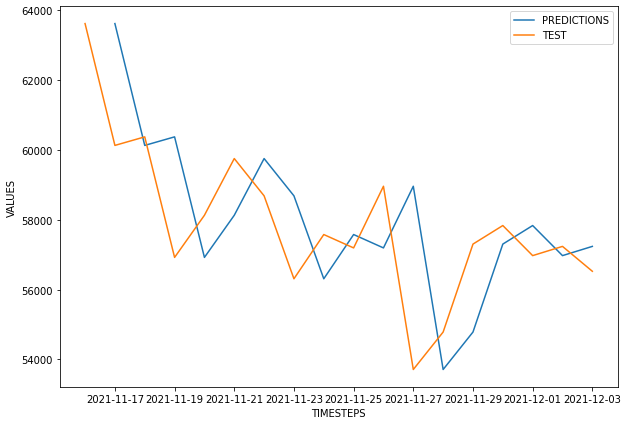

In [17]:
plt.figure(figsize=(10,7))
plot_timeseries(xtest[1:],naive_forecast,label="PREDICTIONS",format='-',start=500)
plot_timeseries(xtest,ytest,label="TEST",format='-',start=500)

# EVALUATING NAIVE MODEL

In [18]:
from sklearn.metrics import mean_absolute_error
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    import numpy as np
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [19]:
def model_report(ytest,forecast):
    
    mae = tf.keras.losses.MeanAbsoluteError()
    mae = mae(ytest,forecast).numpy()
    mse = tf.keras.losses.MeanSquaredError()
    mse = mse(ytest,forecast).numpy()
    rmse = tf.sqrt(mse).numpy()
    mape = tf.keras.losses.mean_absolute_percentage_error(ytest,forecast).numpy()
    if mape.ndim>0:
        mape = tf.reduce_mean(mape).numpy()
    dict = {
        "MEAN ABSOLUTE ERROR":mae,
        "MEAN SQUARED ERROR":mse,
        "ROOT MEAN SQUARED ERROR":rmse,
        "MEAN ABSOLUTE PERCENTAGE ERROR":mape,
    }
    return dict

In [20]:
model0_report = model_report(ytest[1:],naive_forecast)
model0_report

{'MEAN ABSOLUTE ERROR': 1053.4937744140625,
 'MEAN SQUARED ERROR': 2533305.0,
 'ROOT MEAN SQUARED ERROR': 1591.6359508380049,
 'MEAN ABSOLUTE PERCENTAGE ERROR': 2.783683044788772}

# DIVIDING DATA INTO WINDOWS

In [21]:
def make_windows(window_size,horizon_size,data):
    i = 0
    windowed_data = []
    horizon = []
    while(i+window_size+horizon_size<=len(data)):
        lab_data = []
        lab_label = []
        for j in range(i,i+window_size):
            lab_data.append(data[j])
        for j in range(i+window_size,i+window_size+horizon_size):
            lab_label.append(data[j])
        windowed_data.append(lab_data)
        horizon.append(lab_label)
        i+=1
    return np.array(windowed_data),tf.squeeze(np.array(horizon)).numpy()

In [22]:
windows,horizon = make_windows(7,1,prices)

# SPLITTING WINDOWS AND HORIZONS INTO TRAINING AND TESTING DATA

In [23]:
train_win = windows[:int(len(windows)*0.85)]
train_hor = horizon[:int(len(windows)*0.85)]
test_win = windows[int(len(windows)*0.85):]
test_hor = horizon[int(len(windows)*0.85):]
train_win.shape,test_win.shape,train_hor.shape,test_hor.shape

((2193, 7), (387, 7), (2193,), (387,))

# CREATING MODELLING CALLBACK

In [24]:
def create_model_checkpoint(filename):
    import tensorflow as tf
    return tf.keras.callbacks.ModelCheckpoint(filename, 
                                              save_best_only=True)

# MODEL1

In [25]:
# window = 7, horizon = 1
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(1,activation="linear")
],name="model1")
model1.compile(optimizer = tf.keras.optimizers.Adam(), loss = "mae", metrics=["mae", "mse"])
history1 = model1.fit(train_win, 
                    train_hor, 
                    epochs = 100,
                    batch_size = 128,
                    validation_data = (test_win,test_hor),
                    callbacks = [create_model_checkpoint("model1.ckpt")])

Epoch 1/100
18/18 [==============================] - 2s 35ms/step - loss: 2201.6301 - mae: 2201.6301 - mse: 12182351.0000 - val_loss: 4293.6694 - val_mae: 4293.6694 - val_mse: 28050654.0000
Epoch 2/100
18/18 [==============================] - 1s 29ms/step - loss: 476.6562 - mae: 476.6562 - mse: 634767.1875 - val_loss: 3406.0513 - val_mae: 3406.0513 - val_mse: 16868348.0000
Epoch 3/100
18/18 [==============================] - 0s 21ms/step - loss: 276.3743 - mae: 276.3743 - mse: 269228.0938 - val_loss: 2498.4617 - val_mae: 2498.4617 - val_mse: 9735941.0000
Epoch 4/100
18/18 [==============================] - 0s 23ms/step - loss: 220.7973 - mae: 220.7973 - mse: 188386.7344 - val_loss: 1993.4421 - val_mae: 1993.4421 - val_mse: 6711238.5000
Epoch 5/100
18/18 [==============================] - 0s 23ms/step - loss: 205.1697 - mae: 205.1697 - mse: 169871.7344 - val_loss: 1974.7706 - val_mae: 1974.7706 - val_mse: 6368405.0000
Epoch 6/100
18/18 [==============================] - 0s 20ms/step - l

Epoch 31/100
18/18 [==============================] - 0s 22ms/step - loss: 148.4706 - mae: 148.4706 - mse: 94699.6562 - val_loss: 1424.8947 - val_mae: 1424.8947 - val_mse: 3651019.5000
Epoch 32/100
18/18 [==============================] - 0s 4ms/step - loss: 146.4527 - mae: 146.4527 - mse: 94499.7812 - val_loss: 1426.8932 - val_mae: 1426.8932 - val_mse: 3666150.2500
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 149.7677 - mae: 149.7677 - mse: 95429.2031 - val_loss: 1530.8440 - val_mae: 1530.8440 - val_mse: 4044360.0000
Epoch 34/100
18/18 [==============================] - 0s 25ms/step - loss: 158.3769 - mae: 158.3769 - mse: 99319.0391 - val_loss: 1423.4951 - val_mae: 1423.4951 - val_mse: 3667313.0000
Epoch 35/100
18/18 [==============================] - 0s 20ms/step - loss: 147.6066 - mae: 147.6066 - mse: 92476.4531 - val_loss: 1407.8987 - val_mae: 1407.8987 - val_mse: 3589393.2500
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 145

Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 141.2533 - mae: 141.2533 - mse: 86845.9922 - val_loss: 1368.0861 - val_mae: 1368.0861 - val_mse: 3461239.0000
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 138.4368 - mae: 138.4368 - mse: 84363.5312 - val_loss: 1635.8141 - val_mae: 1635.8141 - val_mse: 4457844.5000
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 157.5022 - mae: 157.5022 - mse: 96686.2812 - val_loss: 1471.1719 - val_mae: 1471.1719 - val_mse: 3847531.2500
Epoch 71/100
18/18 [==============================] - 0s 20ms/step - loss: 147.1678 - mae: 147.1678 - mse: 90902.6562 - val_loss: 1353.3154 - val_mae: 1353.3154 - val_mse: 3420009.2500
Epoch 72/100
18/18 [==============================] - 0s 20ms/step - loss: 146.8835 - mae: 146.8835 - mse: 92234.7891 - val_loss: 1345.2660 - val_mae: 1345.2660 - val_mse: 3397888.7500
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 139.

In [26]:
model1 = tf.keras.models.load_model("model1.ckpt")

# EVALUATING MODEL1

In [27]:
model1.evaluate(test_win,test_hor)

13/13 [==============================] - 0s 2ms/step - loss: 1339.2299 - mae: 1339.2299 - mse: 3366366.2500


[1339.2298583984375, 1339.2298583984375, 3366366.25]

In [28]:
pred1 = model1.predict(test_win)
pred1 = tf.squeeze(pred1).numpy()

In [29]:
model1_report = model_report(test_hor,pred1)
model1_report

{'MEAN ABSOLUTE ERROR': 1339.2299,
 'MEAN SQUARED ERROR': 3366366.5,
 'ROOT MEAN SQUARED ERROR': 1834.766,
 'MEAN ABSOLUTE PERCENTAGE ERROR': 3.1417484}

# PLOTTING THE PREDICTIONS OF MODEL1

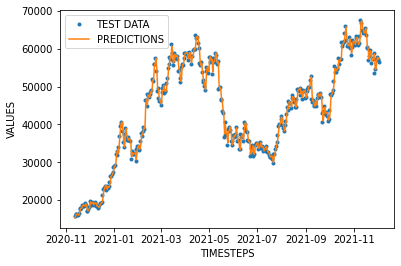

In [30]:
plot_timeseries(timesteps[-int(len(test_hor)):],test_hor,label="TEST DATA")
plot_timeseries(timesteps[-int(len(test_hor)):],pred1,format = '-',label="PREDICTIONS")

# MODEL2

In [31]:
#preparing the data
windows,horizons = make_windows(30,1,prices)
windows.shape,horizons.shape

((2557, 30), (2557,))

In [32]:
train_win = windows[:int(len(windows)*0.8)]
train_hor = horizons[:int(len(windows)*0.8)]
test_win = windows[int(len(windows)*0.8):]
test_hor = horizons[int(len(windows)*0.8):]
len(train_win)

2045

In [33]:
# window = 30, horizon = 1
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(1,activation="linear")
],name="model2")
model2.compile(optimizer = tf.keras.optimizers.Adam(), loss = "mae", metrics=["mae", "mse"])
history2 = model2.fit(train_win, 
                    train_hor, 
                    epochs = 100,
                    batch_size = 128,
                    validation_data = (test_win,test_hor),
                    callbacks = [create_model_checkpoint("model2.ckpt")])

Epoch 1/100
16/16 [==============================] - 1s 29ms/step - loss: 2265.8096 - mae: 2265.8096 - mse: 15660358.0000 - val_loss: 4915.5635 - val_mae: 4915.5635 - val_mse: 48315872.0000
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 758.6044 - mae: 758.6044 - mse: 1855104.8750 - val_loss: 5126.7427 - val_mae: 5126.7427 - val_mse: 52544340.0000
Epoch 3/100
16/16 [==============================] - 0s 23ms/step - loss: 602.2100 - mae: 602.2100 - mse: 1328852.2500 - val_loss: 3567.5144 - val_mae: 3567.5144 - val_mse: 25155268.0000
Epoch 4/100
16/16 [==============================] - 0s 24ms/step - loss: 443.4994 - mae: 443.4994 - mse: 771452.7500 - val_loss: 3324.5388 - val_mae: 3324.5388 - val_mse: 19574594.0000
Epoch 5/100
16/16 [==============================] - 0s 23ms/step - loss: 352.6012 - mae: 352.6012 - mse: 488376.0625 - val_loss: 2313.2388 - val_mae: 2313.2388 - val_mse: 10638668.0000
Epoch 6/100
16/16 [==============================] - 0s 23ms/step

Epoch 33/100
16/16 [==============================] - 0s 23ms/step - loss: 184.2105 - mae: 184.2105 - mse: 128563.1406 - val_loss: 1251.4883 - val_mae: 1251.4883 - val_mse: 3337568.0000
Epoch 34/100
16/16 [==============================] - 0s 23ms/step - loss: 160.7511 - mae: 160.7511 - mse: 110298.2188 - val_loss: 1228.6995 - val_mae: 1228.6995 - val_mse: 3215351.2500
Epoch 35/100
16/16 [==============================] - 0s 23ms/step - loss: 156.8054 - mae: 156.8054 - mse: 106921.0156 - val_loss: 1224.4503 - val_mae: 1224.4503 - val_mse: 3198977.5000
Epoch 36/100
16/16 [==============================] - 0s 23ms/step - loss: 159.2620 - mae: 159.2620 - mse: 109931.2109 - val_loss: 1221.4298 - val_mae: 1221.4298 - val_mse: 3182248.2500
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 169.4020 - mae: 169.4020 - mse: 117510.5625 - val_loss: 1402.4137 - val_mae: 1402.4137 - val_mse: 3853208.0000
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - los

Epoch 69/100
16/16 [==============================] - 0s 4ms/step - loss: 152.8704 - mae: 152.8704 - mse: 98467.2891 - val_loss: 1168.5181 - val_mae: 1168.5181 - val_mse: 2931277.0000
Epoch 70/100
16/16 [==============================] - 0s 4ms/step - loss: 149.4373 - mae: 149.4373 - mse: 97892.6328 - val_loss: 1475.4193 - val_mae: 1475.4193 - val_mse: 4358379.0000
Epoch 71/100
16/16 [==============================] - 0s 23ms/step - loss: 165.1414 - mae: 165.1414 - mse: 106002.7578 - val_loss: 1146.4534 - val_mae: 1146.4534 - val_mse: 2853412.7500
Epoch 72/100
16/16 [==============================] - 0s 4ms/step - loss: 151.3083 - mae: 151.3083 - mse: 99008.7031 - val_loss: 1202.4961 - val_mae: 1202.4961 - val_mse: 3031476.5000
Epoch 73/100
16/16 [==============================] - 0s 11ms/step - loss: 152.1765 - mae: 152.1765 - mse: 100886.1250 - val_loss: 1309.4209 - val_mae: 1309.4209 - val_mse: 3557760.5000
Epoch 74/100
16/16 [==============================] - 0s 4ms/step - loss: 17

# EVALUATING MODEL2

In [34]:
model2.evaluate(test_win,test_hor)

16/16 [==============================] - 0s 2ms/step - loss: 1247.9705 - mae: 1247.9705 - mse: 3173892.0000


[1247.970458984375, 1247.970458984375, 3173892.0]

In [35]:
pred2 = model2.predict(test_win)
pred2 = tf.squeeze(pred2)

In [36]:
model2_report = model_report(test_hor,pred2)
model2_report

{'MEAN ABSOLUTE ERROR': 1247.9705,
 'MEAN SQUARED ERROR': 3173892.0,
 'ROOT MEAN SQUARED ERROR': 1781.542,
 'MEAN ABSOLUTE PERCENTAGE ERROR': 3.3481154}

# PLOTTING THE PREDICTIONS OF MODEL2

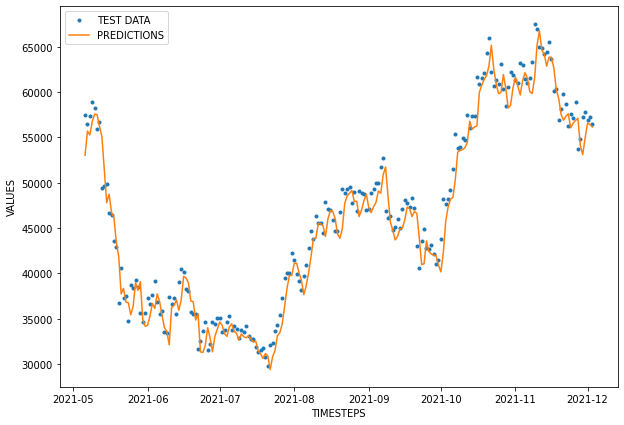

In [37]:
plt.figure(figsize=(10,7))
plot_timeseries(timesteps[-int(len(test_win)):], test_hor,label="TEST DATA",start=300)
plot_timeseries(timesteps[-int(len(test_win)):], pred2, format='-', label="PREDICTIONS",start=300)

# MODEL 3

In [38]:
# preparing the data
windows,horizons = make_windows(30,7,prices)
windows.shape,horizons.shape 

((2551, 30), (2551, 7))

In [39]:
# splitting into train and test data
train_win = windows[:int(len(windows)*0.8)][:]
train_hor = horizons[:int(len(windows)*0.8)][:]
test_win = windows[int(len(windows)*0.8):][:]
test_hor = horizons[int(len(windows)*0.8):][:]
train_win.shape,test_win.shape,train_hor.shape,test_hor.shape

((2040, 30), (511, 30), (2040, 7), (511, 7))

In [40]:
# building model
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(7)
],name="model3")
model3.compile(optimizer = tf.keras.optimizers.Adam(), loss = "mae", metrics=["mae", "mse"])
history3 = model3.fit(train_win, 
                    train_hor, 
                    epochs = 100,
                    batch_size = 128,
                    validation_data = (test_win,test_hor),
                    callbacks = [create_model_checkpoint("model3.ckpt")])

Epoch 1/100
16/16 [==============================] - 1s 29ms/step - loss: 2772.6780 - mae: 2772.6780 - mse: 25159018.0000 - val_loss: 9750.0039 - val_mae: 9750.0039 - val_mse: 279465696.0000
Epoch 2/100
16/16 [==============================] - 0s 24ms/step - loss: 795.8112 - mae: 795.8112 - mse: 2584786.0000 - val_loss: 4851.4346 - val_mae: 4851.4346 - val_mse: 48702684.0000
Epoch 3/100
16/16 [==============================] - 0s 23ms/step - loss: 518.1537 - mae: 518.1537 - mse: 1023233.1875 - val_loss: 3750.1208 - val_mae: 3750.1208 - val_mse: 28786302.0000
Epoch 4/100
16/16 [==============================] - 0s 24ms/step - loss: 449.2865 - mae: 449.2865 - mse: 785346.4375 - val_loss: 3289.0754 - val_mae: 3289.0754 - val_mse: 22551414.0000
Epoch 5/100
16/16 [==============================] - 0s 24ms/step - loss: 422.0651 - mae: 422.0651 - mse: 709638.0000 - val_loss: 3231.2822 - val_mae: 3231.2822 - val_mse: 21829580.0000
Epoch 6/100
16/16 [==============================] - 0s 24ms/st

16/16 [==============================] - 0s 4ms/step - loss: 318.2491 - mae: 318.2491 - mse: 427780.3438 - val_loss: 2519.9170 - val_mae: 2519.9170 - val_mse: 13606207.0000
Epoch 30/100
16/16 [==============================] - 0s 4ms/step - loss: 315.6877 - mae: 315.6877 - mse: 419905.6250 - val_loss: 2501.7117 - val_mae: 2501.7117 - val_mse: 13476185.0000
Epoch 31/100
16/16 [==============================] - 0s 5ms/step - loss: 313.8221 - mae: 313.8221 - mse: 416444.5000 - val_loss: 2504.7009 - val_mae: 2504.7009 - val_mse: 13377692.0000
Epoch 32/100
16/16 [==============================] - 0s 22ms/step - loss: 314.4783 - mae: 314.4783 - mse: 416633.5000 - val_loss: 2444.0632 - val_mae: 2444.0632 - val_mse: 13330236.0000
Epoch 33/100
16/16 [==============================] - 0s 5ms/step - loss: 319.5028 - mae: 319.5028 - mse: 418836.0625 - val_loss: 2517.9036 - val_mae: 2517.9036 - val_mse: 13638943.0000
Epoch 34/100
16/16 [==============================] - 0s 24ms/step - loss: 316.678

16/16 [==============================] - 0s 23ms/step - loss: 296.9988 - mae: 296.9988 - mse: 370106.8125 - val_loss: 2289.7974 - val_mae: 2289.7974 - val_mse: 11541330.0000
Epoch 67/100
16/16 [==============================] - 0s 4ms/step - loss: 294.6481 - mae: 294.6481 - mse: 365707.4062 - val_loss: 2328.7566 - val_mae: 2328.7566 - val_mse: 11724354.0000
Epoch 68/100
16/16 [==============================] - 0s 5ms/step - loss: 294.5917 - mae: 294.5917 - mse: 365878.6250 - val_loss: 2301.4031 - val_mae: 2301.4031 - val_mse: 11516634.0000
Epoch 69/100
16/16 [==============================] - 0s 4ms/step - loss: 298.7109 - mae: 298.7109 - mse: 373056.1875 - val_loss: 2474.0303 - val_mae: 2474.0303 - val_mse: 12593930.0000
Epoch 70/100
16/16 [==============================] - 0s 5ms/step - loss: 298.6616 - mae: 298.6616 - mse: 369194.1562 - val_loss: 2358.7043 - val_mae: 2358.7043 - val_mse: 11920747.0000
Epoch 71/100
16/16 [==============================] - 0s 5ms/step - loss: 293.4753

In [41]:
# loading the best performing model
model3 = tf.keras.models.load_model("model3.ckpt")

# EVALUATING MODEL3

In [42]:
model3.evaluate(test_win,test_hor)

16/16 [==============================] - 0s 2ms/step - loss: 2220.9060 - mae: 2220.9060 - mse: 10973673.0000


[2220.906005859375, 2220.906005859375, 10973673.0]

In [43]:
pred3 = tf.squeeze(model3.predict(test_win)).numpy()
pred3.shape

(511, 7)

In [44]:
model3_report = model_report(test_hor,pred3)
model3_report

{'MEAN ABSOLUTE ERROR': 2220.9062,
 'MEAN SQUARED ERROR': 10973673.0,
 'ROOT MEAN SQUARED ERROR': 3312.6536,
 'MEAN ABSOLUTE PERCENTAGE ERROR': 5.845532}

# MODEL4

In [45]:
# preparing the data
windows, horizons = make_windows(7,1,prices)
windows.shape, horizons.shape

((2580, 7), (2580,))

In [46]:
# splitting into train and test data
train_win = windows[:int(len(windows)*0.8)]
train_hor = horizons[:int(len(windows)*0.8)]
test_win = windows[int(len(windows)*0.8):]
test_hor = horizons[int(len(windows)*0.8):]
train_win.shape,test_win.shape,train_hor.shape,test_hor.shape

((2064, 7), (516, 7), (2064,), (516,))

In [47]:
# building model
# data should be in the form [batch_size, time_steps, ndims]
model4 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=1)),
    tf.keras.layers.Conv1D(128, kernel_size = 5, padding = "causal", activation = "relu"),
    tf.keras.layers.Dense(1) #changing the default activation function
],name = "model4")
model4.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(), metrics = ["mae","mse"])
history4 = model4.fit(train_win,
                      train_hor,
                      batch_size = 128,
                      epochs = 100,
                      validation_data = (test_win,test_hor),
                      callbacks = [create_model_checkpoint("model4.ckpt")])

Epoch 1/100
17/17 [==============================] - 9s 46ms/step - loss: 3796.1934 - mae: 3796.1934 - mse: 25116348.0000 - val_loss: 19256.7480 - val_mae: 19256.7480 - val_mse: 540117248.0000
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 3780.3689 - mae: 3780.3689 - mse: 24981110.0000 - val_loss: 21140.1895 - val_mae: 21140.1895 - val_mse: 630923392.0000
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 3780.2268 - mae: 3780.2268 - mse: 25038508.0000 - val_loss: 20061.2402 - val_mae: 20061.2402 - val_mse: 577846464.0000
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 3782.0107 - mae: 3782.0107 - mse: 24769900.0000 - val_loss: 20285.6426 - val_mae: 20285.6426 - val_mse: 588660224.0000
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 3778.4988 - mae: 3778.4988 - mse: 24852334.0000 - val_loss: 20044.3574 - val_mae: 20044.3574 - val_mse: 577037248.0000
Epoch 6/100
17/17 [====================

Epoch 42/100
17/17 [==============================] - 0s 5ms/step - loss: 3775.0254 - mae: 3775.0254 - mse: 24771456.0000 - val_loss: 21218.4277 - val_mae: 21218.4277 - val_mse: 634897920.0000
Epoch 43/100
17/17 [==============================] - 0s 5ms/step - loss: 3782.7063 - mae: 3782.7063 - mse: 25079290.0000 - val_loss: 19249.3633 - val_mae: 19249.3633 - val_mse: 539653760.0000
Epoch 44/100
17/17 [==============================] - 0s 5ms/step - loss: 3776.0859 - mae: 3776.0859 - mse: 24738436.0000 - val_loss: 21398.4609 - val_mae: 21398.4609 - val_mse: 644068800.0000
Epoch 45/100
17/17 [==============================] - 0s 5ms/step - loss: 3772.8691 - mae: 3772.8691 - mse: 24763298.0000 - val_loss: 20244.6484 - val_mae: 20244.6484 - val_mse: 586638848.0000
Epoch 46/100
17/17 [==============================] - 0s 5ms/step - loss: 3777.4995 - mae: 3777.4995 - mse: 25022362.0000 - val_loss: 19073.1914 - val_mae: 19073.1914 - val_mse: 531584768.0000
Epoch 47/100
17/17 [===============

17/17 [==============================] - 0s 5ms/step - loss: 3774.6243 - mae: 3774.6243 - mse: 24734084.0000 - val_loss: 20870.6719 - val_mae: 20870.6719 - val_mse: 617412416.0000
Epoch 85/100
17/17 [==============================] - 0s 5ms/step - loss: 3766.9968 - mae: 3766.9968 - mse: 24924376.0000 - val_loss: 19606.0293 - val_mae: 19606.0293 - val_mse: 556201216.0000
Epoch 86/100
17/17 [==============================] - 0s 6ms/step - loss: 3773.1680 - mae: 3773.1680 - mse: 24608784.0000 - val_loss: 20851.3301 - val_mae: 20851.3301 - val_mse: 616448320.0000
Epoch 87/100
17/17 [==============================] - 0s 6ms/step - loss: 3780.7136 - mae: 3780.7136 - mse: 25077718.0000 - val_loss: 19943.8926 - val_mae: 19943.8926 - val_mse: 572182464.0000
Epoch 88/100
17/17 [==============================] - 0s 5ms/step - loss: 3777.0591 - mae: 3777.0591 - mse: 24796542.0000 - val_loss: 20519.7930 - val_mae: 20519.7930 - val_mse: 600051456.0000
Epoch 89/100
17/17 [============================

# EVALUATING MODEL4

In [48]:
model4 = tf.keras.models.load_model("model4.ckpt")

In [49]:
model4.evaluate(test_win,test_hor)

17/17 [==============================] - 0s 2ms/step - loss: 18642.4316 - mae: 18642.4316 - mse: 448359840.0000


[18642.431640625, 18642.431640625, 448359840.0]

In [50]:
pred4 = tf.squeeze(model4.predict(test_win)).numpy()
model4_report = model_report(test_hor,pred4)
model4_report

{'MEAN ABSOLUTE ERROR': 18642.43,
 'MEAN SQUARED ERROR': 439573340.0,
 'ROOT MEAN SQUARED ERROR': 20966.004,
 'MEAN ABSOLUTE PERCENTAGE ERROR': 52.35763}

# PLOTTING THE PREDICTIONS OF MODEL4

In [51]:
plt.figure(figsize=(10,7))
plot_timeseries(timesteps[-int(len(test_win)):],test_hor,label="TEST DATA")
plot_timeseries(timesteps[-int(len(test_win)):],pred4,format='-',label="PREDICTIONS")

# MODEL5

In [52]:
# data is same as above
# input also has to be in the same form
model5 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=1)),
    tf.keras.layers.LSTM(128,activation = "relu"),
    tf.keras.layers.Dense(1)
])
model5.compile(loss="mae",optimizer = tf.keras.optimizers.Adam(), metrics=["mae","mse"])
history5 = model5.fit(train_win,
                      train_hor,
                      epochs = 100,
                      batch_size = 128,
                      verbose = 0,
                      validation_data = (test_win,test_hor),
                      callbacks = [create_model_checkpoint("model5.ckpt")])

INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


INFO:tensorflow:Assets written to: model5.ckpt\assets


# EVALUATING MODEL5

In [53]:
model5 = tf.keras.models.load_model("model5.ckpt")

In [54]:
model5.evaluate(test_win, test_hor)

17/17 [==============================] - 0s 3ms/step - loss: 1114.3325 - mae: 1114.3325 - mse: 2743902.7500


[1114.33251953125, 1114.33251953125, 2743902.75]

In [55]:
pred5 = tf.squeeze(model5.predict(test_win)).numpy()
pred5[:10]

array([9112.25 , 9088.219, 9251.534, 9254.448, 9389.934, 9308.558,
       9301.402, 9263.414, 9273.714, 9250.396], dtype=float32)

In [56]:
model5_report = model_report(test_hor,pred5)
model5_report

{'MEAN ABSOLUTE ERROR': 1114.3326,
 'MEAN SQUARED ERROR': 2743902.8,
 'ROOT MEAN SQUARED ERROR': 1656.473,
 'MEAN ABSOLUTE PERCENTAGE ERROR': 2.9406936}

# PLOTTING THE PREDICTIOONS OF MODEL5

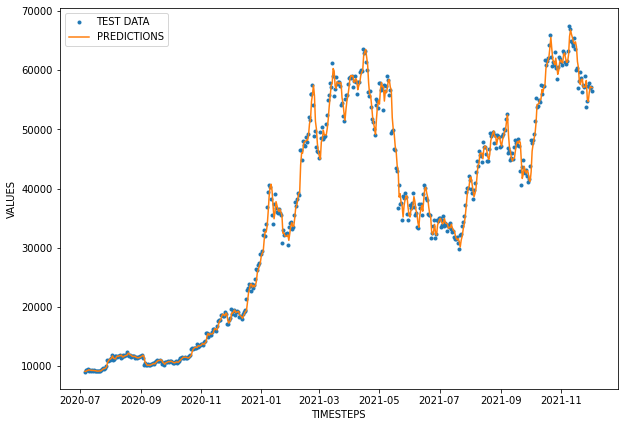

In [57]:
plt.figure(figsize=(10,7))
plot_timeseries(timesteps[-int(len(test_hor)):],test_hor,label ="TEST DATA")
plot_timeseries(timesteps[-int(len(test_hor)):],pred5,format = '-',label ="PREDICTIONS")

# COMPARING RESULTS OF ALL UNIVARIATE TIME SERIES MODELS

In [58]:
pd.DataFrame({
    "NAIVE MODEL":model1_report["MEAN ABSOLUTE ERROR"],
    "DENSE(7,1)":model2_report["MEAN ABSOLUTE ERROR"],
    "DENSE(30,7)":model3_report["MEAN ABSOLUTE ERROR"],
    "CONV1D":model4_report["MEAN ABSOLUTE ERROR"],
    "LSTM":model5_report["MEAN ABSOLUTE ERROR"]
},index = ["MEAN ABSOLUTE ERROR"]).plot(kind = "bar",figsize=(10,7))
plt.title("COMPARISON OF MAE OF ALL MODELS")

Text(0.5, 1.0, 'COMPARISON OF MAE OF ALL MODELS')

# MULTIVARIATE TIME SERIES
* PREPARING THE DATA
* TRAINING A DENSE MODEL

# PREPARING THE DATA

In [59]:
# block reward data is going to be the second variable
block_reward1 = 50
block_reward2 = 25
block_reward3 = 12.25
block_reward4 = 6.25

In [60]:
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [61]:
block_reward_days2 = (block_reward_3_datetime - df_cp.index[0]).days
block_reward_days3 = (block_reward_4_datetime - df_cp.index[0]).days
block_reward_days2, block_reward_days3
# this means that from day 0 to 613 a block reward of 25 was given, from 613 to 2015 
# block reward of 12.5 was given and from 2015 to the end a block reward of 6.25 was given

(613, 2015)

In [88]:
df_cp_block = df_cp.copy()
df_cp_block["block reward"] = None
df_cp_block.iloc[:block_reward_days2,-1] = 25
df_cp_block.iloc[block_reward_days2:block_reward_days3,-1] = 12.5
df_cp_block.iloc[block_reward_days3:,-1] = 6.25
df_cp_block

Price block reward
Date                                 
2014-11-04    324.467934           25
2014-11-05    328.644408           25
2014-11-06    337.921358           25
2014-11-07    348.992860           25
2014-11-08    341.459753           25
...                  ...          ...
2021-11-29  57303.185972         6.25
2021-11-30  57834.357549         6.25
2021-12-01  56973.182042         6.25
2021-12-02  57237.271634         6.25
2021-12-03  56524.829562         6.25

[2587 rows x 2 columns]

# PLOTTING THE DATA

<AxesSubplot:xlabel='Date'>

<Figure size 720x504 with 0 Axes>

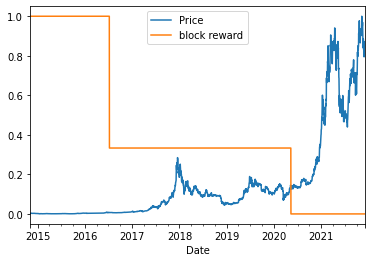

In [89]:
from sklearn.preprocessing import minmax_scale
plt.figure(figsize=(10,7))
df_cp_block_scaled = pd.DataFrame(minmax_scale(df_cp_block[["Price","block reward"]]),
                                  columns = df_cp_block.columns,
                                  index = df_cp_block.index)
df_cp_block_scaled.plot()

# SPLITTING IN WINDOWS AND HORIZONS

In [90]:
window_size = 7
horizon = 1
for i in range(window_size):
    df_cp_block[f'Prices {i}'] = df_cp_block["Price"].shift(periods = i)
df_cp_block.head(10)

Price block reward    Prices 0    Prices 1    Prices 2  \
Date                                                                      
2014-11-04  324.467934           25  324.467934         NaN         NaN   
2014-11-05  328.644408           25  328.644408  324.467934         NaN   
2014-11-06  337.921358           25  337.921358  328.644408  324.467934   
2014-11-07  348.992860           25  348.992860  337.921358  328.644408   
2014-11-08  341.459753           25  341.459753  348.992860  337.921358   
2014-11-09  344.745289           25  344.745289  341.459753  348.992860   
2014-11-10  357.239982           25  357.239982  344.745289  341.459753   
2014-11-11  371.116917           25  371.116917  357.239982  344.745289   
2014-11-12  366.664633           25  366.664633  371.116917  357.239982   
2014-11-13  428.882925           25  428.882925  366.664633  371.116917   

              Prices 3    Prices 4    Prices 5    Prices 6  
Date                                                        
2014-11-04         NaN         NaN         NaN         NaN  
2014-11-05         NaN         NaN         NaN         NaN  
2014-11-06         NaN         NaN         NaN         NaN  
2014-11-07  324.467934         NaN         NaN         NaN  
2014-11-08  328.644408  324.467934         NaN         NaN  
2014-11-09  337.921358  328.644408  324.467934         NaN  
2014-11-10  348.992860  337.921358  328.644408  324.467934  
2014-11-11  341.459753  348.992860  337.921358  328.644408  
2014-11-12  344.745289  341.459753  348.992860  337.921358  
2014-11-13  357.239982  344.745289  341.459753  348.992860

In [91]:
x = df_cp_block.dropna().drop(["Price"],axis=1).astype(np.float32)
y = df_cp_block.dropna()["Price"].astype(np.float32)

In [94]:
#splitting into training and testing data
train_win = x[:int(len(x)*0.8)][:]
test_win = x[int(len(x)*0.8):][:]
train_hor = y[:int(len(x)*0.8)][:]
test_hor = y[int(len(x)*0.8):][:]
train_win.shape,train_hor.shape,test_win.shape,test_hor.shape

((2064, 8), (2064,), (517, 8), (517,))

# MODEL6

In [98]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(1)
],name="model6")
model6.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(), metrics = ["mae","mse"])
history6 = model6.fit(train_win,
                      train_hor,
                      epochs = 100,
                      validation_data = (test_win,test_hor),
                       batch_size = 128,
                      callbacks = [create_model_checkpoint("model6")])

Epoch 1/100
16/17 [===========================>..] - ETA: 0s - loss: 2414.4944 - mae: 2414.4944 - mse: 14552424.0000INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 1s 27ms/step - loss: 2398.9592 - mae: 2398.9592 - mse: 14444698.0000 - val_loss: 2888.7822 - val_mae: 2888.7822 - val_mse: 14826768.0000
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 462.9113 - mae: 462.9113 - mse: 599183.0000 - val_loss: 2971.6338 - val_mae: 2971.6338 - val_mse: 13809322.0000
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 223.1998 - mae: 223.1998 - mse: 177010.5938INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 23ms/step - loss: 223.1998 - mae: 223.1998 - mse: 177010.5938 - val_loss: 1506.7377 - val_mae: 1506.7377 - val_mse: 4386474.0000
Epoch 4/100
16/17 [===========================>..] - ETA: 0s - loss: 180.6263 - mae: 180.6263 - mse: 136640.0000INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 24ms/step - loss: 181.1416 - mae: 181.1416 - mse: 137079.2500 - val_loss: 1350.7345 - val_mae: 1350.7345 - val_mse: 3689753.5000
Epoch 5/100
17/17 [==============================] - ETA: 0s - loss: 171.3260 - mae: 171.3260 - mse: 125694.2734INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 23ms/step - loss: 171.3260 - mae: 171.3260 - mse: 125694.2734 - val_loss: 1291.3738 - val_mae: 1291.3738 - val_mse: 3437019.2500
Epoch 6/100
15/17 [=========================>....] - ETA: 0s - loss: 168.7056 - mae: 168.7056 - mse: 119857.2500INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 25ms/step - loss: 166.9896 - mae: 166.9896 - mse: 117659.1094 - val_loss: 1290.5530 - val_mae: 1290.5530 - val_mse: 3315105.7500
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 180.0625 - mae: 180.0625 - mse: 124689.5312 - val_loss: 1343.4624 - val_mae: 1343.4624 - val_mse: 3456049.7500
Epoch 8/100
17/17 [==============================] - ETA: 0s - loss: 161.4871 - mae: 161.4871 - mse: 106929.1875INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 24ms/step - loss: 161.4871 - mae: 161.4871 - mse: 106929.1875 - val_loss: 1165.9263 - val_mae: 1165.9263 - val_mse: 2915797.0000
Epoch 9/100
17/17 [==============================] - ETA: 0s - loss: 144.0855 - mae: 144.0855 - mse: 89803.1953INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 24ms/step - loss: 144.0855 - mae: 144.0855 - mse: 89803.1953 - val_loss: 1071.2870 - val_mae: 1071.2870 - val_mse: 2414502.5000
Epoch 10/100
17/17 [==============================] - 0s 5ms/step - loss: 140.4917 - mae: 140.4917 - mse: 84786.7500 - val_loss: 1217.3114 - val_mae: 1217.3114 - val_mse: 2782215.0000
Epoch 11/100
17/17 [==============================] - ETA: 0s - loss: 131.9159 - mae: 131.9159 - mse: 74338.6172INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 24ms/step - loss: 131.9159 - mae: 131.9159 - mse: 74338.6172 - val_loss: 959.2737 - val_mae: 959.2737 - val_mse: 1941835.2500
Epoch 12/100
17/17 [==============================] - ETA: 0s - loss: 122.6400 - mae: 122.6400 - mse: 65868.7891INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 31ms/step - loss: 122.6400 - mae: 122.6400 - mse: 65868.7891 - val_loss: 954.7001 - val_mae: 954.7001 - val_mse: 1825383.8750
Epoch 13/100
16/17 [===========================>..] - ETA: 0s - loss: 118.0704 - mae: 118.0704 - mse: 59640.9961INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 23ms/step - loss: 118.7826 - mae: 118.7826 - mse: 60052.4883 - val_loss: 872.9857 - val_mae: 872.9857 - val_mse: 1586773.3750
Epoch 14/100
17/17 [==============================] - 0s 5ms/step - loss: 112.0688 - mae: 112.0688 - mse: 55567.3711 - val_loss: 1007.5082 - val_mae: 1007.5082 - val_mse: 1915656.0000
Epoch 15/100
15/17 [=========================>....] - ETA: 0s - loss: 110.2054 - mae: 110.2054 - mse: 51834.6602INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 24ms/step - loss: 109.9667 - mae: 109.9667 - mse: 51231.7734 - val_loss: 845.2344 - val_mae: 845.2344 - val_mse: 1557178.5000
Epoch 16/100
16/17 [===========================>..] - ETA: 0s - loss: 104.1168 - mae: 104.1168 - mse: 46856.8789INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 24ms/step - loss: 104.8987 - mae: 104.8987 - mse: 47034.5312 - val_loss: 753.8067 - val_mae: 753.8067 - val_mse: 1202962.5000
Epoch 17/100
16/17 [===========================>..] - ETA: 0s - loss: 102.7586 - mae: 102.7586 - mse: 44415.3203INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 23ms/step - loss: 102.5324 - mae: 102.5324 - mse: 44181.7188 - val_loss: 716.2845 - val_mae: 716.2845 - val_mse: 1094944.2500
Epoch 18/100
17/17 [==============================] - ETA: 0s - loss: 94.2329 - mae: 94.2329 - mse: 38444.2031  INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 94.2329 - mae: 94.2329 - mse: 38444.2031 - val_loss: 700.3281 - val_mae: 700.3281 - val_mse: 1026900.8750
Epoch 19/100
17/17 [==============================] - 0s 4ms/step - loss: 90.2145 - mae: 90.2145 - mse: 34987.6289 - val_loss: 728.1251 - val_mae: 728.1251 - val_mse: 1145110.3750
Epoch 20/100
 1/17 [>.............................] - ETA: 0s - loss: 89.0124 - mae: 89.0124 - mse: 27071.4219INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 24ms/step - loss: 92.8885 - mae: 92.8885 - mse: 35404.5781 - val_loss: 665.9138 - val_mae: 665.9138 - val_mse: 921803.8750
Epoch 21/100
 1/17 [>.............................] - ETA: 0s - loss: 102.8765 - mae: 102.8765 - mse: 34176.0859INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 24ms/step - loss: 90.9767 - mae: 90.9767 - mse: 32624.8750 - val_loss: 609.4304 - val_mae: 609.4304 - val_mse: 798473.0000
Epoch 22/100
17/17 [==============================] - 0s 4ms/step - loss: 82.6189 - mae: 82.6189 - mse: 29612.7988 - val_loss: 686.5394 - val_mae: 686.5394 - val_mse: 939176.0000
Epoch 23/100
 1/17 [>.............................] - ETA: 0s - loss: 82.1217 - mae: 82.1217 - mse: 20042.4980INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 80.0756 - mae: 80.0756 - mse: 27209.2422 - val_loss: 571.8015 - val_mae: 571.8015 - val_mse: 700593.1250
Epoch 24/100
17/17 [==============================] - 0s 4ms/step - loss: 73.3010 - mae: 73.3010 - mse: 24199.5137 - val_loss: 642.6355 - val_mae: 642.6355 - val_mse: 825171.5625
Epoch 25/100
17/17 [==============================] - 0s 4ms/step - loss: 75.8719 - mae: 75.8719 - mse: 23883.5859 - val_loss: 625.9077 - val_mae: 625.9077 - val_mse: 776525.6250
Epoch 26/100
 1/17 [>.............................] - ETA: 0s - loss: 60.4457 - mae: 60.4457 - mse: 12170.6787INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 79.4946 - mae: 79.4946 - mse: 23455.0469 - val_loss: 496.3159 - val_mae: 496.3159 - val_mse: 536757.3750
Epoch 27/100
 1/17 [>.............................] - ETA: 0s - loss: 54.2107 - mae: 54.2107 - mse: 12459.3027INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 23ms/step - loss: 65.2371 - mae: 65.2371 - mse: 18958.1562 - val_loss: 472.4680 - val_mae: 472.4680 - val_mse: 488377.1875
Epoch 28/100
 1/17 [>.............................] - ETA: 0s - loss: 70.3879 - mae: 70.3879 - mse: 19642.9746INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 61.1645 - mae: 61.1645 - mse: 16605.3594 - val_loss: 451.5946 - val_mae: 451.5946 - val_mse: 445844.0000
Epoch 29/100
 1/17 [>.............................] - ETA: 0s - loss: 62.8772 - mae: 62.8772 - mse: 14706.2266INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 23ms/step - loss: 56.4518 - mae: 56.4518 - mse: 13956.7783 - val_loss: 411.3920 - val_mae: 411.3920 - val_mse: 366409.1250
Epoch 30/100
17/17 [==============================] - 0s 4ms/step - loss: 54.2339 - mae: 54.2339 - mse: 12452.3066 - val_loss: 414.6499 - val_mae: 414.6499 - val_mse: 360963.6562
Epoch 31/100
17/17 [==============================] - 0s 4ms/step - loss: 52.1122 - mae: 52.1122 - mse: 11400.2910 - val_loss: 435.1379 - val_mae: 435.1379 - val_mse: 393267.1875
Epoch 32/100
 1/17 [>.............................] - ETA: 0s - loss: 66.5264 - mae: 66.5264 - mse: 14338.2988INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 54.6507 - mae: 54.6507 - mse: 11313.9189 - val_loss: 337.6207 - val_mae: 337.6207 - val_mse: 254865.3906
Epoch 33/100
 1/17 [>.............................] - ETA: 0s - loss: 42.8693 - mae: 42.8693 - mse: 8529.3125INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 48.9328 - mae: 48.9328 - mse: 9724.2539 - val_loss: 325.5435 - val_mae: 325.5435 - val_mse: 236377.4219
Epoch 34/100
 1/17 [>.............................] - ETA: 0s - loss: 44.2489 - mae: 44.2489 - mse: 16755.1133INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 21ms/step - loss: 42.1417 - mae: 42.1417 - mse: 7860.6738 - val_loss: 310.8433 - val_mae: 310.8433 - val_mse: 213857.9531
Epoch 35/100
 1/17 [>.............................] - ETA: 0s - loss: 27.8234 - mae: 27.8234 - mse: 2796.5518INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 45.5452 - mae: 45.5452 - mse: 8152.7637 - val_loss: 287.5854 - val_mae: 287.5854 - val_mse: 181350.5312
Epoch 36/100
17/17 [==============================] - 0s 4ms/step - loss: 38.2436 - mae: 38.2436 - mse: 6388.7939 - val_loss: 473.9712 - val_mae: 473.9712 - val_mse: 388684.8750
Epoch 37/100
17/17 [==============================] - 0s 4ms/step - loss: 66.3542 - mae: 66.3542 - mse: 13394.2939 - val_loss: 503.1904 - val_mae: 503.1904 - val_mse: 421585.5625
Epoch 38/100
 1/17 [>.............................] - ETA: 0s - loss: 54.1653 - mae: 54.1653 - mse: 7772.8604INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 50.1679 - mae: 50.1679 - mse: 7943.5679 - val_loss: 267.5211 - val_mae: 267.5211 - val_mse: 152717.6094
Epoch 39/100
17/17 [==============================] - 0s 4ms/step - loss: 43.8154 - mae: 43.8154 - mse: 6677.1611 - val_loss: 289.5849 - val_mae: 289.5849 - val_mse: 172355.7656
Epoch 40/100
 1/17 [>.............................] - ETA: 0s - loss: 43.0447 - mae: 43.0447 - mse: 4987.5625INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 41.8397 - mae: 41.8397 - mse: 6515.5596 - val_loss: 237.4967 - val_mae: 237.4967 - val_mse: 122616.8984
Epoch 41/100
17/17 [==============================] - 0s 4ms/step - loss: 45.0299 - mae: 45.0299 - mse: 6943.6870 - val_loss: 364.1942 - val_mae: 364.1942 - val_mse: 247201.2188
Epoch 42/100
17/17 [==============================] - 0s 4ms/step - loss: 53.7415 - mae: 53.7415 - mse: 8522.0420 - val_loss: 254.0163 - val_mae: 254.0163 - val_mse: 134522.6250
Epoch 43/100
 1/17 [>.............................] - ETA: 0s - loss: 36.9110 - mae: 36.9110 - mse: 5101.7207INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 23ms/step - loss: 31.9547 - mae: 31.9547 - mse: 4283.3057 - val_loss: 225.2127 - val_mae: 225.2127 - val_mse: 107499.1484
Epoch 44/100
 1/17 [>.............................] - ETA: 0s - loss: 23.1001 - mae: 23.1001 - mse: 1682.4069INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 23ms/step - loss: 28.8989 - mae: 28.8989 - mse: 3556.6575 - val_loss: 207.3592 - val_mae: 207.3592 - val_mse: 92926.5547
Epoch 45/100
17/17 [==============================] - 0s 4ms/step - loss: 26.8552 - mae: 26.8552 - mse: 3187.0723 - val_loss: 217.1571 - val_mae: 217.1571 - val_mse: 98426.1719
Epoch 46/100
17/17 [==============================] - 0s 4ms/step - loss: 27.1415 - mae: 27.1415 - mse: 3112.4333 - val_loss: 237.1108 - val_mae: 237.1108 - val_mse: 111754.3438
Epoch 47/100
 1/17 [>.............................] - ETA: 0s - loss: 22.6875 - mae: 22.6875 - mse: 2192.5078INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 21ms/step - loss: 25.9623 - mae: 25.9623 - mse: 2736.0488 - val_loss: 190.3251 - val_mae: 190.3251 - val_mse: 76376.8359
Epoch 48/100
17/17 [==============================] - 0s 4ms/step - loss: 27.1181 - mae: 27.1181 - mse: 2788.8838 - val_loss: 214.0287 - val_mae: 214.0287 - val_mse: 91256.0078
Epoch 49/100
 1/17 [>.............................] - ETA: 0s - loss: 25.3278 - mae: 25.3278 - mse: 2488.7415INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 30ms/step - loss: 30.7439 - mae: 30.7439 - mse: 3289.8433 - val_loss: 167.3333 - val_mae: 167.3333 - val_mse: 59370.6172
Epoch 50/100
17/17 [==============================] - 0s 4ms/step - loss: 25.7021 - mae: 25.7021 - mse: 2457.7288 - val_loss: 265.1208 - val_mae: 265.1208 - val_mse: 125989.4688
Epoch 51/100
 1/17 [>.............................] - ETA: 0s - loss: 32.6562 - mae: 32.6562 - mse: 2747.3423INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 21ms/step - loss: 24.2173 - mae: 24.2173 - mse: 2210.3416 - val_loss: 155.3519 - val_mae: 155.3519 - val_mse: 50998.9023
Epoch 52/100
17/17 [==============================] - 0s 4ms/step - loss: 19.9358 - mae: 19.9358 - mse: 1686.0596 - val_loss: 190.1256 - val_mae: 190.1256 - val_mse: 70036.2031
Epoch 53/100
17/17 [==============================] - 0s 4ms/step - loss: 30.9896 - mae: 30.9896 - mse: 3099.6013 - val_loss: 390.8836 - val_mae: 390.8836 - val_mse: 229853.2656
Epoch 54/100
17/17 [==============================] - 0s 4ms/step - loss: 29.1670 - mae: 29.1670 - mse: 2694.5137 - val_loss: 265.5331 - val_mae: 265.5331 - val_mse: 119090.9062
Epoch 55/100
17/17 [==============================] - 0s 4ms/step - loss: 22.6812 - mae: 22.6812 - mse: 1810.0159 - val_loss: 194.1996 - val_mae: 194.1996 - val_mse: 69905.7266
Epoch 56/100
 1/17 [>.............................] - ETA: 0s - loss: 23.6083 - mae: 23.6083 - mse: 1943.8112INFO:tensorflow:

INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 18.2462 - mae: 18.2462 - mse: 1344.2902 - val_loss: 125.0756 - val_mae: 125.0756 - val_mse: 32817.3789
Epoch 57/100
17/17 [==============================] - 0s 4ms/step - loss: 25.4557 - mae: 25.4557 - mse: 2065.7380 - val_loss: 191.3081 - val_mae: 191.3081 - val_mse: 65693.8047
Epoch 58/100
17/17 [==============================] - 0s 4ms/step - loss: 27.4201 - mae: 27.4201 - mse: 2323.6895 - val_loss: 141.8403 - val_mae: 141.8403 - val_mse: 39815.5156
Epoch 59/100
17/17 [==============================] - 0s 4ms/step - loss: 27.2303 - mae: 27.2303 - mse: 2390.2766 - val_loss: 481.8388 - val_mae: 481.8388 - val_mse: 316661.8125
Epoch 60/100
17/17 [==============================] - 0s 4ms/step - loss: 72.5192 - mae: 72.5192 - mse: 13455.9971 - val_loss: 1077.3325 - val_mae: 1077.3325 - val_mse: 1494871.5000
Epoch 61/100
17/17 [==============================] - 0s 4ms/step - loss: 74.3729 - mae: 74.3729 - mse: 15792.7393 - val_

INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 23ms/step - loss: 26.7145 - mae: 26.7145 - mse: 2138.7263 - val_loss: 121.4414 - val_mae: 121.4414 - val_mse: 29497.4258
Epoch 63/100
17/17 [==============================] - 0s 4ms/step - loss: 23.6705 - mae: 23.6705 - mse: 1793.1595 - val_loss: 125.6214 - val_mae: 125.6214 - val_mse: 30939.9414
Epoch 64/100
17/17 [==============================] - 0s 4ms/step - loss: 21.2102 - mae: 21.2102 - mse: 1578.3828 - val_loss: 474.7516 - val_mae: 474.7516 - val_mse: 305783.5625
Epoch 65/100
17/17 [==============================] - 0s 4ms/step - loss: 47.2118 - mae: 47.2118 - mse: 5862.7046 - val_loss: 448.2853 - val_mae: 448.2853 - val_mse: 274146.3438
Epoch 66/100
17/17 [==============================] - 0s 4ms/step - loss: 28.0450 - mae: 28.0450 - mse: 2374.1392 - val_loss: 330.9438 - val_mae: 330.9438 - val_mse: 156699.5000
Epoch 67/100
 1/17 [>.............................] - ETA: 0s - loss: 40.5035 - mae: 40.5035 - mse: 4719.3857INFO:tensorflow

INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 23ms/step - loss: 30.5812 - mae: 30.5812 - mse: 2551.3953 - val_loss: 99.0745 - val_mae: 99.0745 - val_mse: 19895.2188
Epoch 68/100
 1/17 [>.............................] - ETA: 0s - loss: 13.4552 - mae: 13.4552 - mse: 584.4015INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 43.2664 - mae: 43.2664 - mse: 4836.5337 - val_loss: 91.6059 - val_mae: 91.6059 - val_mse: 17580.4961
Epoch 69/100
17/17 [==============================] - 0s 4ms/step - loss: 16.1289 - mae: 16.1289 - mse: 904.8958 - val_loss: 155.4846 - val_mae: 155.4846 - val_mse: 41712.2930
Epoch 70/100
17/17 [==============================] - 0s 4ms/step - loss: 18.7566 - mae: 18.7566 - mse: 1152.1781 - val_loss: 327.4518 - val_mae: 327.4518 - val_mse: 148223.9844
Epoch 71/100
17/17 [==============================] - 0s 4ms/step - loss: 31.9570 - mae: 31.9570 - mse: 2643.3230 - val_loss: 208.4242 - val_mae: 208.4242 - val_mse: 66500.4453
Epoch 72/100
17/17 [==============================] - 0s 4ms/step - loss: 25.6955 - mae: 25.6955 - mse: 1784.7192 - val_loss: 347.4318 - val_mae: 347.4318 - val_mse: 165002.6719
Epoch 73/100
17/17 [==============================] - 0s 4ms/step - loss: 46.1469 - mae: 46.1469 - mse: 4911.4688 - val_loss: 47

INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 23.3337 - mae: 23.3337 - mse: 1461.2312 - val_loss: 77.7691 - val_mae: 77.7691 - val_mse: 12348.7139
Epoch 77/100
 1/17 [>.............................] - ETA: 0s - loss: 11.6459 - mae: 11.6459 - mse: 776.5244INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 16.3297 - mae: 16.3297 - mse: 954.6659 - val_loss: 70.3911 - val_mae: 70.3911 - val_mse: 10317.1191
Epoch 78/100
17/17 [==============================] - 0s 4ms/step - loss: 20.4601 - mae: 20.4601 - mse: 1170.4092 - val_loss: 194.3378 - val_mae: 194.3378 - val_mse: 56054.6250
Epoch 79/100
17/17 [==============================] - 0s 4ms/step - loss: 36.5473 - mae: 36.5473 - mse: 3494.3633 - val_loss: 227.6997 - val_mae: 227.6997 - val_mse: 73811.3438
Epoch 80/100
17/17 [==============================] - 0s 4ms/step - loss: 44.2366 - mae: 44.2366 - mse: 4414.2656 - val_loss: 247.8554 - val_mae: 247.8554 - val_mse: 86111.6328
Epoch 81/100
17/17 [==============================] - 0s 4ms/step - loss: 55.2301 - mae: 55.2301 - mse: 7585.1714 - val_loss: 640.4884 - val_mae: 640.4884 - val_mse: 526512.4375
Epoch 82/100
17/17 [==============================] - 0s 4ms/step - loss: 43.6213 - mae: 43.6213 - mse: 4569.7485 - val_loss: 304

INFO:tensorflow:Assets written to: model6\assets


17/17 [==============================] - 0s 22ms/step - loss: 18.3229 - mae: 18.3229 - mse: 889.8119 - val_loss: 47.4178 - val_mae: 47.4178 - val_mse: 4723.3721
Epoch 96/100
17/17 [==============================] - 0s 4ms/step - loss: 21.2838 - mae: 21.2838 - mse: 1562.0544 - val_loss: 480.0083 - val_mae: 480.0083 - val_mse: 295880.9375
Epoch 97/100
17/17 [==============================] - 0s 4ms/step - loss: 47.8921 - mae: 47.8921 - mse: 5391.7397 - val_loss: 272.7986 - val_mae: 272.7986 - val_mse: 97904.8594
Epoch 98/100
17/17 [==============================] - 0s 4ms/step - loss: 36.6617 - mae: 36.6617 - mse: 3064.6594 - val_loss: 407.1646 - val_mae: 407.1646 - val_mse: 213028.4375
Epoch 99/100
17/17 [==============================] - 0s 4ms/step - loss: 54.7281 - mae: 54.7281 - mse: 7108.9712 - val_loss: 152.5401 - val_mae: 152.5401 - val_mse: 33395.8242
Epoch 100/100
17/17 [==============================] - 0s 4ms/step - loss: 38.7336 - mae: 38.7336 - mse: 3817.3477 - val_loss: 17

# EVALUATING MODEL6

In [99]:
model6 = tf.keras.models.load_model("model6")

In [100]:
model6.evaluate(test_win, test_hor)

17/17 [==============================] - 0s 2ms/step - loss: 47.4177 - mae: 47.4177 - mse: 4723.3428


[47.41765213012695, 47.41765213012695, 4723.3427734375]

In [101]:
pred6 = tf.squeeze(model6.predict(test_win)).numpy()
model6_report = model_report(test_hor, pred6)
model6_report

{'MEAN ABSOLUTE ERROR': 47.417652,
 'MEAN SQUARED ERROR': 4723.3423,
 'ROOT MEAN SQUARED ERROR': 68.72658,
 'MEAN ABSOLUTE PERCENTAGE ERROR': 0.12513582}

# PLOTTING THE PREDICTIONS OF MODEL6

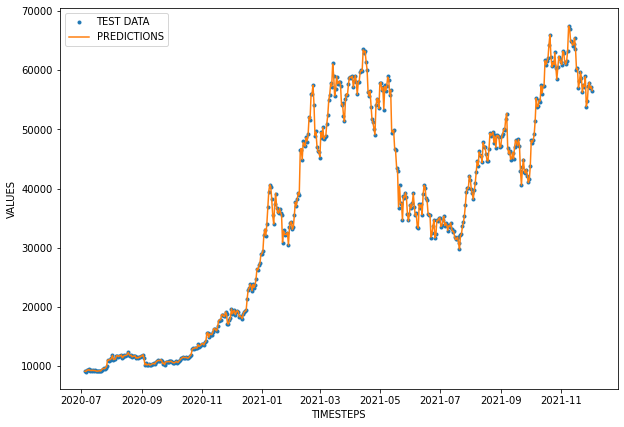

In [114]:
plt.figure(figsize=(10,7))
plot_timeseries(timesteps[-int(len(test_hor)):], test_hor.values, label = "TEST DATA")
plot_timeseries(timesteps[-int(len(test_hor)):], pred6, format = '-',label = "PREDICTIONS")